# 4. Evaluation Metrics for Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv"

In [3]:
!wget $data -O data.csv 

--2022-09-29 02:11:40--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  71.53K  --.-KB/s    in 0.002s  

2022-09-29 02:11:40 (40.4 MB/s) - ‘data.csv’ saved [73250/73250]



In [4]:
df = pd.read_csv('data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [13]:
df.columns

Index(['reports', 'age', 'income', 'share', 'expenditure', 'owner', 'selfemp',
       'dependents', 'months', 'majorcards', 'active', 'target'],
      dtype='object')

In [7]:
df["target"] = (df.card == 'yes').astype(int)

In [8]:
del df['card']

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

In [33]:
numerical = ['age', 'income', 'share',"reports", 'dependents','expenditure','months', 'majorcards', 'active',]
categorical = ['owner','selfemp',]

## Question 1

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

In [34]:
for x in numerical:
  score = roc_auc_score(y_train, df_train[x])
  print(f"{x}:{score}")

age:0.4759979020592945
income:0.5908049467233478
share:0.989183643423692
reports:0.28333701393106236
dependents:0.46722427722262094
expenditure:0.991042345276873
months:0.470578221903237
majorcards:0.5343859842838476
active:0.6043173411362006


The variable with the highest AUC is share

In [21]:
df["age"] = - df["age"]
df["dependents"] = - df["dependents"]
df["months"] = - df["months"]

In [22]:
df.columns

Index(['reports', 'age', 'income', 'share', 'expenditure', 'owner', 'selfemp',
       'dependents', 'months', 'majorcards', 'active', 'target'],
      dtype='object')

## Model

In [26]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [28]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

### AUC score

In [27]:
from sklearn.metrics import roc_curve

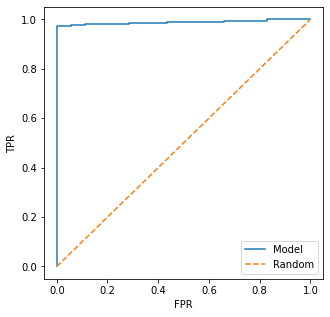

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [30]:
auc(fpr, tpr)

0.988732898148976

The AUC score of this model is 0.988

### Precision and recall

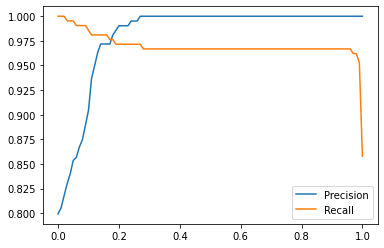

In [32]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    scores.append((t, p, r))

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

They intersect at around 0.1

### Maximizing F1 score

In [35]:
df_scores["f1_score"] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall )

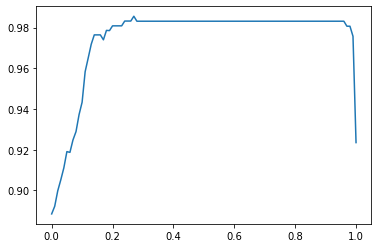

In [36]:
plt.plot(df_scores.threshold, df_scores['f1_score'], label='f1_score')

### Cross-validation

In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [42]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_full_train.target.values
y_test = df_test.target.values
del df_train['target']
del df_test['target']
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [44]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.996 (0.003)


The standard deviation is 0.003


### Optimize parameter C

In [45]:
for C in [0.01, 0.1, 1, 10]:
  cv = KFold(n_splits=5, shuffle=True, random_state=1)
  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv)
  print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.992 (0.006)
Accuracy: 0.995 (0.004)
Accuracy: 0.996 (0.003)
Accuracy: 0.996 (0.003)


The C with the best score is 1.0